This notebook presents an application of `Scouter` to the [Adamson](https://www.sciencedirect.com/science/article/pii/S0092867416316609) dataset, including 86 one-gene perturbations generated using Perturb-seq.

In [11]:
import pickle
import torch
import anndata as ad
import pandas as pd
import numpy as np
import random
from scouter import Scouter, ScouterData

Please provide the following file paths:
- `embd_path`: the path of the LLM embeddings generated from each gene's text description
- `data_path`: the path of the dataset that include gene expression for both perturbed and control cells, in the form of `.h5ad`

#### If you plan to use your own customized data. Please make sure to do the following quality controls:
- each cell's perturbation group is well annotated
- remove the inefficiently perturbed cells. For example, removing the cells whose knock-outed gene's expression is still similarly high as control cells.

In [24]:
data_path = '/Users/pancake/Downloads/Perturb/Gears/adamson/Gears_data/adamson/perturb_processed.h5ad'
embd_path = '/Users/pancake/Downloads/Perturb/scOracle/GeneEmb/GenePT_emb/GenePT_gene_embedding_ada_text.pickle'

In [23]:
def set_seeds(seed=24):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
# Normalize the condition name. Make "A+B" and "B+A" the same
def condition_sort(x):
    return '+'.join(sorted(x.split('+')))

# Set seeds for reproducibility
set_seeds(24)

In [19]:
# Load the processed scRNA-seq dataset as Anndata
adata = ad.read_h5ad(data_path)
adata.obs['condition'] = adata.obs['condition'].astype(str).apply(lambda x: condition_sort(x)).astype('category')
adata.uns = {}; adata.obs.drop('condition_name', axis=1, inplace=True)
print(adata)

AnnData object with n_obs × n_vars = 68603 × 5060
    obs: 'condition', 'cell_type', 'dose_val', 'control'
    var: 'gene_name'


In [27]:
# check the number of cells under each genetic perturbation
print(adata.obs.condition.value_counts())

condition
ctrl            24263
IER3IP1+ctrl     1267
YIPF5+ctrl       1182
SCYL1+ctrl       1024
HSPA5+ctrl       1002
                ...  
HARS+ctrl         272
CAD+ctrl          242
COPZ1+ctrl        220
PPWD1+ctrl        190
COPB1+ctrl        185
Name: count, Length: 87, dtype: int64


Load the gene embedding as a `pandas.DataFrame`\
In order to make `Scouter` aware of that `'GeneA+ctrl'` denotes a one-gene perturbation but `'GeneA+GeneB'` denotes a two-gene perturbation, please add a row of zeros for `'ctrl'` to the embedding dataframe, unless the perturbation in your `adata` is annotated as `'GeneA'` vs `'GeneA+GeneB'`
\
\
**Note: it is possible that there exist some perturbed genes not presented in your provided embedding dataframe. However:**
- theoratically, as long as there is text description for that gene, you can always obtain embeddings for it.
- this unmatch might due to the different gene symbols for the actually same gene. See example [here](UnmatchedGenes.ipynb).

In [30]:
with open(embd_path, 'rb') as f:
    embd = pd.DataFrame(pickle.load(f)).T
ctrl_row = pd.DataFrame([np.zeros(embd.shape[1])], columns=embd.columns, index=['ctrl'])
embd = pd.concat([ctrl_row, embd])
embd

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
ctrl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG,-0.043067,-0.020245,-0.002102,-0.017412,-0.004772,0.018790,-0.014167,0.031064,-0.031476,-0.015532,...,0.017876,0.011861,0.018005,-0.022229,-0.010683,0.012982,-0.017103,-0.046699,-0.006304,0.005322
A1BG-AS1,-0.027003,-0.006847,0.007299,-0.025647,-0.014492,0.028187,-0.025594,0.015941,-0.013449,-0.011075,...,0.005185,-0.005292,0.023267,-0.001981,-0.007359,0.017417,-0.014718,-0.044753,-0.007658,-0.001966
A1CF,-0.040730,-0.014075,0.006621,-0.016098,-0.014863,0.028676,-0.013485,0.035556,-0.019065,-0.008430,...,0.016544,0.017621,-0.017489,-0.015796,-0.027547,0.031906,-0.001667,-0.029385,-0.015073,-0.006473
A2M,-0.029095,-0.001240,-0.015252,-0.025177,-0.012216,0.018987,-0.026927,0.009624,-0.008991,0.006676,...,0.029121,-0.007874,0.013072,-0.018191,-0.007998,0.017277,0.000805,-0.049257,0.005132,0.001392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KRTAP28p1,-0.023102,-0.027802,0.012746,-0.025011,-0.025319,0.011838,-0.012279,0.012532,-0.002612,-0.001223,...,0.021593,0.001784,-0.006917,-0.015584,-0.016211,0.015237,-0.004383,-0.029992,-0.011564,-0.028737
ELOC26,-0.018420,-0.001902,0.016638,-0.047502,-0.040348,0.031001,-0.014815,0.021983,-0.009484,0.016926,...,-0.009923,-0.017529,-0.000795,-0.000451,-0.016761,0.033331,-0.005880,-0.003310,0.013431,-0.021874
FASRL,-0.020013,-0.018781,0.006378,-0.025457,-0.029833,0.016620,-0.011967,0.019238,-0.029445,0.005222,...,0.003350,0.005149,0.013137,-0.017991,-0.004148,0.010685,-0.019307,-0.018268,-0.019376,-0.017714
COMT2,-0.021027,-0.005336,-0.008690,-0.036186,-0.029208,0.038274,-0.008141,0.021674,-0.031666,0.009516,...,0.014181,0.013824,-0.018714,-0.005782,-0.021146,0.024820,0.002504,-0.003615,-0.014974,-0.036582


`ScouterData` is a dataloader that combiens the gene expression and gene embeddigns together, and prepares the training of `Scouter`. The function takes as input:
- `adata`: the adata object that contains gene expression and cell annotations
- `embd`: the dataframe that contains ge
- `key_label`: The column name of `adata.obs` that corresponds to perturbation conditions
- `key_var_genename`: The column name of `adata.var` that corresponds to gene names. This is for readability of plots later, where you can show genes in their names instead of index or ensembl ids.

In [31]:
pertdata = ScouterData(adata=adata, embd=embd, key_label='condition', key_var_genename='gene_name')

We perform the follwing necessary preprocessing for the smooth training of `Scouter` later:
- `pertdata.setup_ad(key_embd_index)`: Setup `adata` and `embd`.
        `embd` will be filtered so that it only contains the matched genes to save memory usage.
        `adata` will drop the perturbation conditions not covered by matched genes.
        A new column named `key_embd_index` will be added to `adata.obs`, denoting the index of perturbed genes in `embd`.

- `pertdata.gene_ranks()`: Rank genes for each perturbation group. Saved as a dictionary in `adata.uns['rank_genes_groups']`. We need this step for model measurement, because we only calculate the metric across top20 DEGs.

- `pertdata.get_dropout_non_zero_genes()`: Compute the non-zero genes and top 20 differentially expressed genes for each perturbation group. We perform this step because in the loss function of `Scouter`, we only calculate the loss on non-zeros of each group.

- `pertdata.split_Train_Val_Test(seed)`: split the data into three sets: Training, Validation, and Testing, based on the random seed `seed`.

In [32]:
pertdata.setup_ad('embd_index')
pertdata.gene_ranks()
pertdata.get_dropout_non_zero_genes()
pertdata.split_Train_Val_Test(seed=1)

All 87 perturbed genes are found in the gene embedding matrix!


We train `Scouter` model on `pertdata`. This is a supervised training, so we would recommend a hyperparameter searching based on the metrics on validation set for both `Scouter.model_init()` and `Scouter.train()`. However, across the experiments on five different datasets in our work, we notice most hyparameters are not sensitive. Therefore, users are welcome to start with our default parameters. For a efficient searching, we recommend targeting on these parameters:
- `loss_gamma` in `Scouter.train()`: $\gamma$ in $L_\text{autofocus}$. `loss_gamma=0` denotes MSE loss. `loss_gamma=0` returns the best result on all five datasets in our work.
- `loss_lambda` in `Scouter.train()`: $\lambda$ in $L=L_\text{autofocus}+\lambda L_\text{direnction}$
- `lr` in `Scouter.train()`: learning rate
- gene embedding source: In this example, we use the embeddings provided by [GenePT](https://github.com/yiqunchen/GenePT). However, there are some other embeddings available online. The author of [scELMo](https://sites.google.com/yale.edu/scelmolib) collected a series of embeddings for biological terms.

In [6]:
scouter_model = Scouter(pertdata)
scouter_model.model_init()
scouter_model.train()

Epoch 1/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 25.28batch/s]


Epoch 1/40, Training Loss: 0.7375, Validation Loss: 0.5977


Epoch 2/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 22.97batch/s]


Epoch 2/40, Training Loss: 0.6095, Validation Loss: 0.5725


Epoch 3/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 24.57batch/s]


Epoch 3/40, Training Loss: 0.6000, Validation Loss: 0.5704


Epoch 4/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 22.07batch/s]


Epoch 4/40, Training Loss: 0.5968, Validation Loss: 0.5682


Epoch 5/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 24.04batch/s]


Epoch 5/40, Training Loss: 0.5927, Validation Loss: 0.5614


Epoch 6/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 25.69batch/s]


Epoch 6/40, Training Loss: 0.5900, Validation Loss: 0.5607


Epoch 7/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 25.66batch/s]


Epoch 7/40, Training Loss: 0.5880, Validation Loss: 0.5589


Epoch 8/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 24.20batch/s]


Epoch 8/40, Training Loss: 0.5871, Validation Loss: 0.5601


Epoch 9/40 - Validation Batches: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 25.64batch/s]


Epoch 9/40, Training Loss: 0.5855, Validation Loss: 0.5623


Epoch 10/40 - Validation Batches: 100%|████████████████████████████████| 15/15 [00:00<00:00, 26.15batch/s]


Epoch 10/40, Training Loss: 0.5841, Validation Loss: 0.5584


Epoch 11/40 - Validation Batches: 100%|████████████████████████████████| 15/15 [00:00<00:00, 21.52batch/s]


Epoch 11/40, Training Loss: 0.5826, Validation Loss: 0.5578


Epoch 12/40 - Validation Batches: 100%|████████████████████████████████| 15/15 [00:00<00:00, 26.07batch/s]


Epoch 12/40, Training Loss: 0.5812, Validation Loss: 0.5544


Epoch 13/40 - Validation Batches: 100%|████████████████████████████████| 15/15 [00:00<00:00, 24.93batch/s]


Epoch 13/40, Training Loss: 0.5804, Validation Loss: 0.5561


Epoch 14/40 - Validation Batches: 100%|████████████████████████████████| 15/15 [00:00<00:00, 24.54batch/s]


Epoch 14/40, Training Loss: 0.5792, Validation Loss: 0.5548


Epoch 15/40 - Validation Batches: 100%|████████████████████████████████| 15/15 [00:00<00:00, 20.71batch/s]


Epoch 15/40, Training Loss: 0.5788, Validation Loss: 0.5541


Epoch 16/40 - Validation Batches: 100%|████████████████████████████████| 15/15 [00:00<00:00, 22.18batch/s]


Epoch 16/40, Training Loss: 0.5775, Validation Loss: 0.5540


Epoch 17/40 - Validation Batches: 100%|████████████████████████████████| 15/15 [00:00<00:00, 19.90batch/s]


Epoch 17/40, Training Loss: 0.5765, Validation Loss: 0.5559
Early stopping after 17 epochs


We calculate the metrics for each perturbation in the test set. The metric are all calculated across top20 DEGs.

In [34]:
metric_df = scouter_model.evaluate()
metric_df

,NormMSE,Pearson,Spearman
BHLHE40+ctrl,1.001355,-0.090827,0.940351
HARS+ctrl,0.119429,0.970638,0.956140
ATP5B+ctrl,0.051742,0.992881,0.943860
DERL2+ctrl,0.088730,0.944180,0.984211
TELO2+ctrl,0.133042,0.917733,1.000000
MRPL39+ctrl,0.138851,0.925654,0.901754
MANF+ctrl,0.015940,0.997436,0.998246
TARS+ctrl,0.372606,0.827349,0.985965
TTI1+ctrl,0.309619,0.943642,0.947368
SRP72+ctrl,0.015458,0.990845,0.998246


For a given perturbation in the Testing set, `Scouter.barplot()` renders a barplot of its control, predicition, and true expression levels on top20 DEGs.

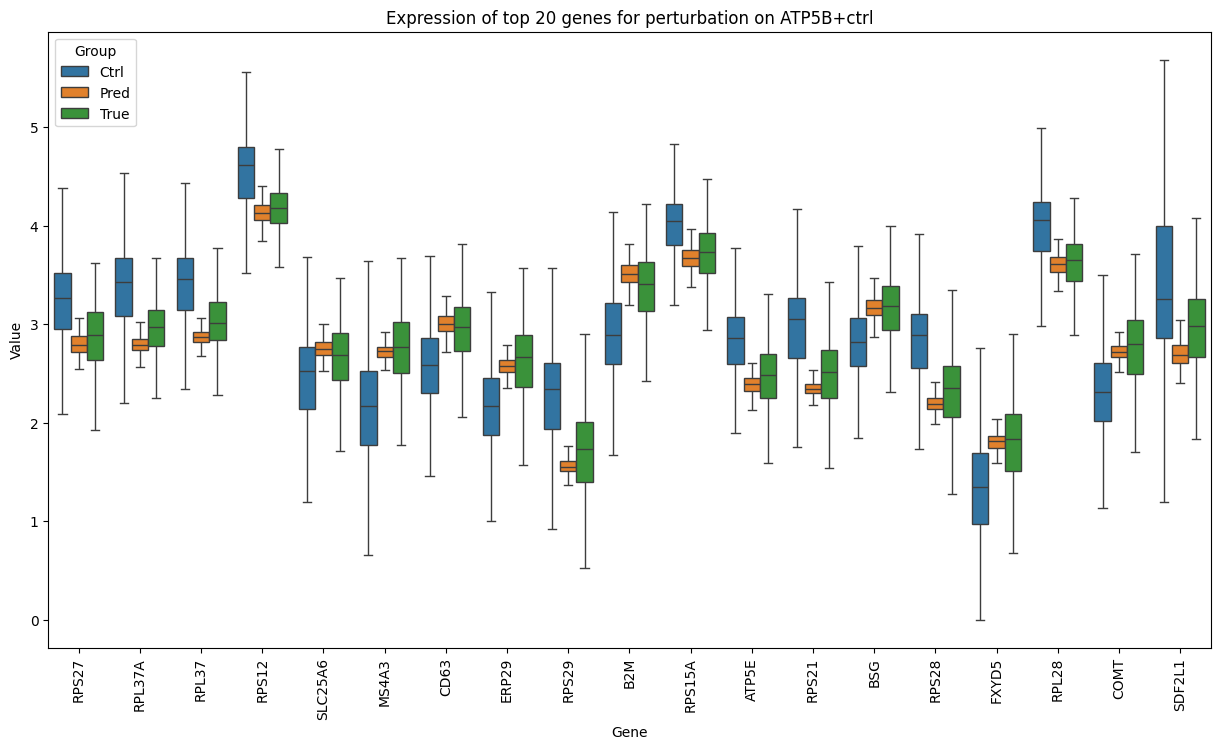

In [35]:
scouter_model.barplot('ATP5B+ctrl')